In [32]:
import torch
import gym
import time
import numpy as np
import importlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [34]:
import hedging_gym, asset_price_models, option_price_models, dqn_utils
_ = importlib.reload(hedging_gym)
_ = importlib.reload(asset_price_models)
_ = importlib.reload(option_price_models)
_ = importlib.reload(dqn_utils)

from hedging_gym import HedgingEnv
from asset_price_models import GBM
from option_price_models import BSM
from dqn_utils import predict_while_training, predict_while_testing
from dqn_utils import add_to_training_set, train, create_dqn

In [35]:
np.random.seed(0)
torch.manual_seed(0)

# option model paramaters
strike_price             = 100
rf_interest_rate         = 0.01
T                        = 1.0

# asset model parameters
mu                       = 0
vol                      = 0.15
dt                       = T / 128
S_0                      = 100

# hedging gym parameters
max_steps                = 100
option_contracts         = 100
initial_holding_fraction = 0.5
trading_cost_parameter   = 0.1
trading_cost_gradient    = 0.01

# DQN parameters
num_hidden               = 1
hidden_dim               = 20
discount                 = 0.8
epsilon_decay            = 0.999
learning_rate            = 0.001

asset_price_model  = GBM(mu, vol, S_0, dt)
option_price_model = BSM(strike_price, rf_interest_rate, vol, T, dt)
env                = HedgingEnv(asset_price_model, option_price_model, max_steps, option_contracts,
                                initial_holding_fraction, trading_cost_parameter, trading_cost_gradient)
dqn                = create_dqn(num_hidden, hidden_dim, discount, epsilon_decay, learning_rate, env)

In [36]:
num_episodes = 10001

rows = []

for episode in range(num_episodes):
    if episode % 50 == 0:
        print(f"processing episode {episode}")
    
    done  = False
    state = env.reset()

    hedging_pnls = []
    trading_pnls = []
    rewards      = []
    
    while not done:
        new_h                 = predict_while_training(dqn, state)
        
        new_state, pnls, done = env.step(new_h.item())
        reward                = 1e5 * (0.005*np.sum(pnls) - np.sum(pnls)**2)
        
        add_to_training_set(dqn, state, new_h, new_state, reward, done)
        state = new_state
        
        hedging_pnls.append(pnls[0])
        trading_pnls.append(pnls[1])
        rewards.append(reward)

        
    if episode > 250:
        rows.append({
            'hedging_pnl' : np.mean(hedging_pnls), 
            'hedging_std' : np.std(hedging_pnls), 
            'trading_pnl' : np.mean(trading_pnls),
            'reward'      : np.mean(rewards)   
        })
            
        for k in range(int(env.max_steps)):
            train(dqn)


processing episode 0
processing episode 50
processing episode 100
processing episode 150
processing episode 200
processing episode 250
processing episode 300
processing episode 350
processing episode 400
processing episode 450
processing episode 500
processing episode 550
processing episode 600
processing episode 650
processing episode 700
processing episode 750
processing episode 800
processing episode 850
processing episode 900
processing episode 950
processing episode 1000
processing episode 1050
processing episode 1100
processing episode 1150
processing episode 1200
processing episode 1250
processing episode 1300
processing episode 1350
processing episode 1400
processing episode 1450
processing episode 1500
processing episode 1550
processing episode 1600
processing episode 1650
processing episode 1700
processing episode 1750
processing episode 1800
processing episode 1850
processing episode 1900
processing episode 1950
processing episode 2000
processing episode 2050
processing epis

In [37]:
df_rl = pd.DataFrame(rows)

In [38]:
rows = []

for j in range(1000):
    done  = False
    state = env.reset()

    hedging_pnls = []
    trading_pnls = []
    rewards      = []

    while not done:
        new_h                 = round(env.option_delta() * env.OCS)
#         print(state[0], new_h, env.option_delta())

        new_state, pnls, done = env.step(new_h)
        reward                = 1e5 * (0.005*np.sum(pnls) - np.sum(pnls)**2)

        state = new_state

        hedging_pnls.append(pnls[0])
        trading_pnls.append(pnls[1])
        rewards.append(reward)

    rows.append({
            'hedging_pnl' : np.mean(hedging_pnls),
            'hedging_std' : np.std(hedging_pnls),
            'trading_pnl' : np.mean(trading_pnls),
            'reward'      : np.mean(rewards)   
    })

In [39]:
df_manual = pd.DataFrame(rows)

<AxesSubplot:>

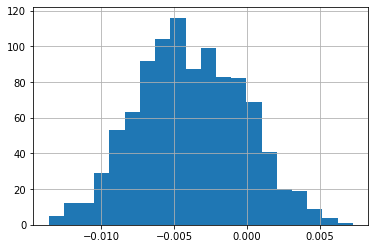

In [40]:
df_manual['hedging_pnl'].hist(bins=20)

<AxesSubplot:>

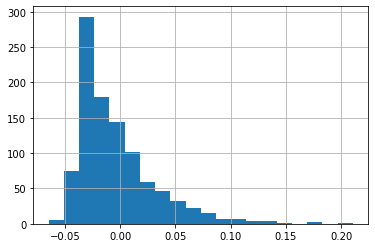

In [41]:
df_rl[:1000]['hedging_pnl'].hist(bins=20)

<AxesSubplot:>

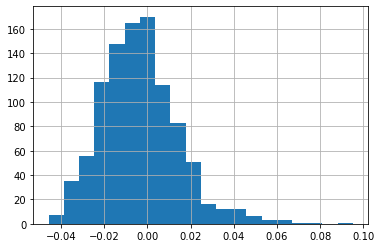

In [42]:
df_rl[-1000:]['hedging_pnl'].hist(bins=20)

In [ ]:
new_state, pnls, done

<AxesSubplot:>

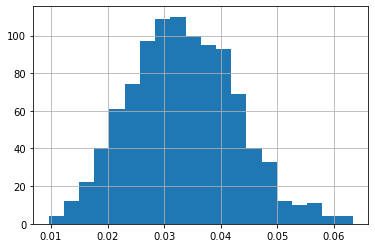

In [44]:
df_manual['hedging_std'].hist(bins=20)

<AxesSubplot:>

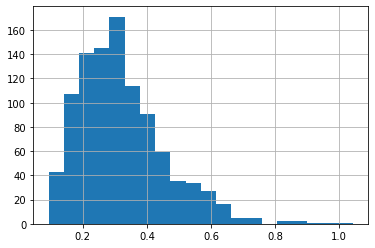

In [45]:
df_rl[:1000]['hedging_std'].hist(bins=20)

<AxesSubplot:>

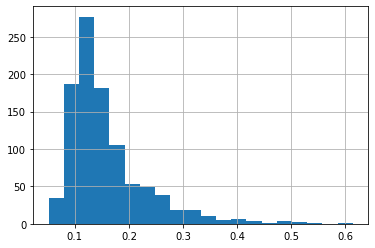

In [46]:
df_rl[-1000:]['hedging_std'].hist(bins=20)